In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import statsmodels
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError
from dataclasses import dataclass
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima

In [ ]:
!pip install pmdarima

In [2]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed_everything(0)

In [6]:
BASE_DIR = 'data_feed/'
# Set the hyperparameters
HIDDEN_SIZE = 18
NUM_EPOCHS = 100
LAG = 10
N_STOCK = 20
BATCH_SIZE = 32
NUM_LAYERS = 2
NUM_HEADS = 1
DROPOUT = 0.1
LOG_FREQUENCY = 10
# whether or not to read all the data from the directory and merge them 
# or simply read the already merged data from disk
PREPROCESS_DATA = False

In [7]:
device = torch.device("cpu")
if torch.cuda.is_available():
   device = torch.device("cuda")
DEVICE = device

## Data Preprocessing

This preprocessing is used both for the econometrical approach and for the neural network approach.<br/>
It simply reads all the Stock Data and joins them into a unique DataFrame containing all close data, then splits the data into train and test

In [8]:
# check if data_feed directory exist if not 
# assert os.path.exists(BASE_DIR)
# list all the files in the data_feed directory
files = os.listdir(BASE_DIR)

In [9]:
def rename_columns(df: pd.DataFrame, file_name: str) -> None:
    """
    modify columns names (exept date) into the following structure: 
        *column_name*_*stock_name* 
        
    Example: Open_AAPL
    """
    df.rename(columns=dict(zip(df.columns[1:], df.columns[1:] + '_' + file_name[:-4])), inplace=True)

In [18]:
if PREPROCESS_DATA:
    # Read First File into a pandas dataframe
    df = pd.read_csv(BASE_DIR+files[0])
    rename_columns(df, files[0])

    # Merge Everything into a unique DataFrame
    for fn in files[1:]:
        df2 = pd.read_csv(BASE_DIR+fn)
        rename_columns(df2, fn)
        result = df.merge(df2, on='Date')
        df = result

    df.set_index('Date',inplace=True)
    df.index = pd.to_datetime(df.index)

    cols = [col for col in df.columns if "Adj Close" in col]
    df = df[cols]


    # Save all the data onto a file
    df.to_csv('AGGREGATED_DATA.csv')

    split_date = df.index[0] + pd.offsets.DateOffset(years=8)
    train_data = df[df.index <= split_date]
    test_data = df[df.index > split_date]
    test_data.to_csv('TEST.csv')
    train_data.to_csv('TRAIN.csv')
else:
    test_data = pd.read_csv('TEST.csv')
    test_data.set_index('Date',inplace=True)
    
    train_data = pd.read_csv('TRAIN.csv')
    train_data.set_index('Date',inplace=True)
    
    df = pd.read_csv('AGGREGATED_DATA.csv')
    df.set_index('Date',inplace=True)
df

,Adj Close_JPM,Adj Close_MCD,Adj Close_MSFT,Adj Close_MA,Adj Close_NKE,Adj Close_KO,Adj Close_V,Adj Close_UNH,Adj Close_HD,Adj Close_GOOGL,Adj Close_WMT,Adj Close_AAPL,Adj Close_PFE,Adj Close_META,Adj Close_XOM,Adj Close_TSLA,Adj Close_PG,Adj Close_AMZN,Adj Close_DIS,Adj Close_JNJ
Date,,,,,,,,,,,,,,,,,,,,
2013-01-02,33.557884,67.764633,22.668230,47.946114,23.057137,27.239820,36.085690,46.601398,50.027016,18.099348,55.018860,16.813860,16.847834,28.000000,57.143978,2.357333,51.112915,12.865500,46.454647,53.172245
2013-01-03,33.490261,68.148109,22.364573,48.014702,23.292870,27.239820,36.113560,44.422565,49.885159,18.109859,54.669235,16.601631,16.808819,27.770000,57.040913,2.318000,50.788795,12.924000,46.554646,53.097202
2013-01-04,34.083874,67.561607,21.945997,48.012817,23.519712,27.283285,36.408508,44.507999,49.790588,18.467718,54.875820,16.139196,16.880348,28.760000,57.305016,2.293333,50.891937,12.957500,47.445557,53.705181
2013-01-07,34.121429,68.358665,21.904966,48.844898,23.555288,27.022480,36.668621,44.507999,49.522655,18.387136,54.351383,16.044262,16.893353,29.420000,56.641525,2.289333,50.545738,13.423000,46.336464,53.592598
2013-01-08,34.189068,68.381218,21.790058,48.684105,23.306217,26.834118,37.010006,43.918457,49.822113,18.350851,54.502361,16.087444,16.919361,29.059999,56.995811,2.245333,50.464714,13.319000,46.145554,53.600075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-11,136.050003,293.233490,309.433533,383.390015,121.819016,63.860001,231.009995,488.760010,285.633667,116.570000,153.119995,173.510010,37.580002,235.789993,104.879921,172.080002,154.389999,112.180000,92.309998,159.784439
2023-05-12,134.100006,294.576355,308.296051,381.920013,119.815605,64.110001,231.380005,491.230011,288.393799,117.510002,153.070007,172.570007,37.349998,233.809998,104.870003,167.979996,155.960007,110.260002,91.989998,159.576004
2023-05-15,135.229996,294.337616,308.784973,383.410004,119.436852,63.939999,232.809998,486.859985,286.477600,116.510002,151.880005,172.070007,37.160000,238.860001,105.070000,166.350006,156.009995,111.199997,92.860001,158.355209


# Econometric Forecasting

`auto_arima` is a function used in time series analysis to automatically determine the optimal parameters for an ARIMA (AutoRegressive Integrated MovingAverage) model. ARIMA models are commonly used to forecast future values based on past observations.
The `auto_arima` function uses an iterative approach to search for the best combination of parameters (p, d, q) for the ARIMA model.
By automatically determining the optimal parameters, `auto_arima` simplifies the process of fitting an ARIMA model to time series data and helps in generating more accurate forecasts.

`VARMA` is an acronym for Vector Autoregressive Moving Average. It is a statistical model used for analyzing and forecasting multivariate time series data. The advantage is that VARMA models can handle multiple time series variables simultaneously.
VARMA models combine autoregressive (AR) and moving average (MA) components to capture the linear relationships and dependencies among the variables. The "vector" in VARMA refers to the fact that each variable is modeled as a linear combination of lagged values of all variables in the system.


In our project, we have used `auto_arima` to automatically select the optimal parameters for an ARIMA model, and then used VARMA with the same parameters to analyze and perform forecasting on multiple time series variables simultaneously.

In [19]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====> Reject the null hypothesis: Data is stationary")
    else:
        print("Conclusion:====> Fail to reject the null hypothesis: Data is non-stationary")

In [20]:
for column in df.columns:
    Augmented_Dickey_Fuller_Test_func(df[column].values,column)

Results of Dickey-Fuller Test for column: Adj Close_JPM
Test Statistic                   -0.917164
p-value                           0.782268
No Lags Used                     19.000000
Number of Observations Used    2592.000000
Critical Value (1%)              -3.432875
Critical Value (5%)              -2.862656
Critical Value (10%)             -2.567364
dtype: float64
Conclusion:====> Fail to reject the null hypothesis: Data is non-stationary
Results of Dickey-Fuller Test for column: Adj Close_MCD
Test Statistic                    0.618135
p-value                           0.988054
No Lags Used                     27.000000
Number of Observations Used    2584.000000
Critical Value (1%)              -3.432883
Critical Value (5%)              -2.862659
Critical Value (10%)             -2.567366
dtype: float64
Conclusion:====> Fail to reject the null hypothesis: Data is non-stationary
Results of Dickey-Fuller Test for column: Adj Close_MSFT
Test Statistic                    0.668098
p-va

In [21]:
train_data_diff = train_data.diff()
train_data_diff.dropna(inplace=True)

In [22]:
for column in train_data.columns:
    Augmented_Dickey_Fuller_Test_func(train_data_diff[column].values,column)

Results of Dickey-Fuller Test for column: Adj Close_JPM
Test Statistic                -8.467899e+00
p-value                        1.505041e-13
No Lags Used                   2.600000e+01
Number of Observations Used    1.987000e+03
Critical Value (1%)           -3.433645e+00
Critical Value (5%)           -2.862996e+00
Critical Value (10%)          -2.567545e+00
dtype: float64
Conclusion:====> Reject the null hypothesis: Data is stationary
Results of Dickey-Fuller Test for column: Adj Close_MCD
Test Statistic                -9.023285e+00
p-value                        5.698635e-15
No Lags Used                   2.600000e+01
Number of Observations Used    1.987000e+03
Critical Value (1%)           -3.433645e+00
Critical Value (5%)           -2.862996e+00
Critical Value (10%)          -2.567545e+00
dtype: float64
Conclusion:====> Reject the null hypothesis: Data is stationary
Results of Dickey-Fuller Test for column: Adj Close_MSFT
Test Statistic                -1.195559e+01
p-value      

Find the best order pairs for each stock using `auto_arima`; then find the most common 'best order' pair (p,q).

In [ ]:
pq = []
max_pdq = 3
for column in train_data.columns:
    print(f'Searching order of p and q for : {column}')
    stepwise_model = auto_arima(train_data[column].values, start_p=1, start_q=1, max_p=max_pdq, max_q=max_pdq, seasonal=False,
        error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{column} is: {parameter} \n\n')
    pq.append(parameter)

In [ ]:
from collections import Counter

def valore_piu_frequente(lista):
    conteggio = Counter(lista)
    valore_piu_comune = conteggio.most_common(1)[0][0]
    return valore_piu_comune

best_order_pq = valore_piu_frequente(pq)

## Model Train

In theory we wanted to apply VARMAX using the most frequent 'best-order' pair of order, but in practical, for computational reasons, we have applied VARMAX using the order pair (1,0).

In [ ]:
# Apply VARMAX
#model = VARMAX(scaled_train_df.values, exog=None, order=(best_order_pq[0], best_order_pq[2]))
model = VARMAX(train_data_diff.values, exog=None, order=(1,0))

In [ ]:
model_fit = model.fit(maxiter=50, disp=True)

# Save the model
model_fit.save('varmax_model.pkl')

## Model Inference

In [23]:
model_fit = statsmodels.api.load_pickle('varmax_model.pkl')

In [24]:
# Model Forecasting
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Calculate residuals
residuals = test_data - predictions

# Calculate covariance matrix
cov_matrix = np.cov(residuals.T)

print("Forecasted Covariance Matrix:")
print(cov_matrix)


x_0 = np.expand_dims(test_data.iloc[0].values, 0)
predictions = np.r_[x_0, predictions].cumsum(axis=0)[1:, :]
mae = mean_absolute_error(test_data.values, predictions)
print('*'*50)
print(f"MAE: {mae}")

Forecasted Covariance Matrix:
[[ 2.30435694e+02 -4.98002644e+01  2.06335941e+02  1.76321106e+02
   2.62002612e+02 -3.56904264e+01  1.26325043e+02 -4.67182896e+02
   2.96237147e+02  1.51186837e+02  4.12049065e+01 -1.36504931e+01
  -1.84963254e+01  9.49175525e+02 -1.74308334e+02  1.24494216e+02
   5.79004600e-01  2.66558785e+02  3.65602658e+02 -4.52448540e+01]
 [-4.98002644e+01  5.01935193e+02  2.08965965e+02  7.68912020e+01
  -1.45574078e+02  9.73434122e+01  3.62965701e+01  1.09437494e+03
   1.97096649e+02 -5.85858461e+01  9.04813650e+01  2.05775273e+02
   6.86467342e+01 -8.87440669e+02  4.31636680e+02 -3.51201605e+02
   1.62584479e+02 -4.49778548e+02 -6.15311952e+02  6.86464269e+01]
 [ 2.06335941e+02  2.08965965e+02  9.35670641e+02  1.56903408e+02
   3.91531080e+02  3.34834988e+01  1.20633261e+02  3.64240918e+02
   7.39027730e+02  4.69027878e+02  9.61964563e+01  3.51096434e+02
   8.70954227e+01  1.15936168e+03 -8.35578504e+01  1.07622120e+03
   1.91186608e+02  3.63410970e+02  1.2249837

In [25]:
def plot_predictions_econometric(predictions, scaled: bool):
    all_pred = predictions

    if scaled:
      all_pred = scaler.inverse_transform(all_pred)
      all_real = np.concatenate((scaled_train, scaled_test))
      all_real = scaler.inverse_transform(all_real)
      all_real.shape[0]
    else:
      all_real = np.concatenate((train_data, test_data))
      all_real.shape[0]

    for idx, file_name in enumerate(files):
        stock = file_name[:-4]
        index_test_start = all_real[:, 0].shape[0] - all_pred.shape[0]
        plt.figure()
        plt.plot(range(all_real.shape[0]) , all_real[:, idx], label='real')
        plt.plot(range(index_test_start,all_real.shape[0]), all_pred[:, idx], color='orange', label='forecast')
        plt.axvline(x=index_test_start, color='red', linestyle='--')
        plt.title(stock)
        plt.legend()
        plt.show()

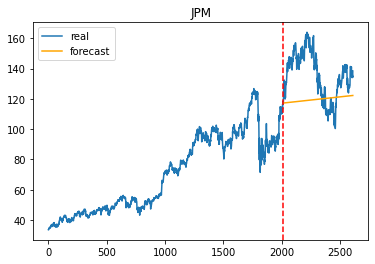

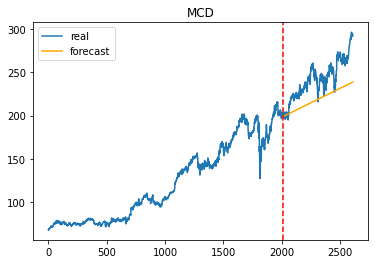

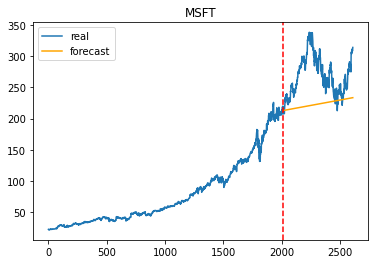

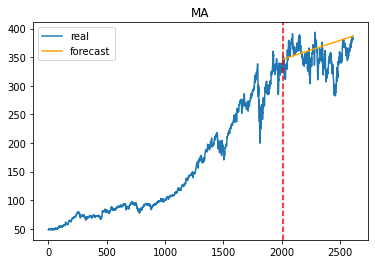

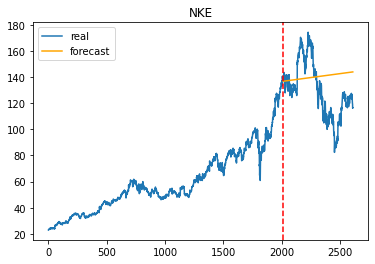

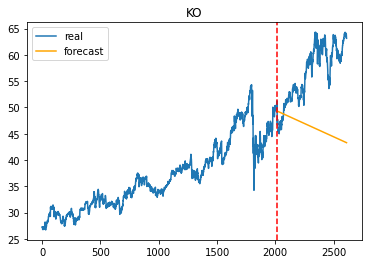

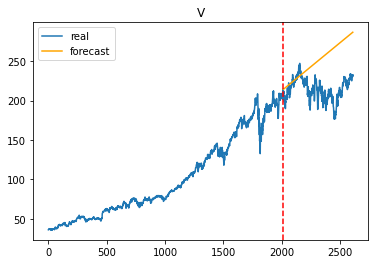

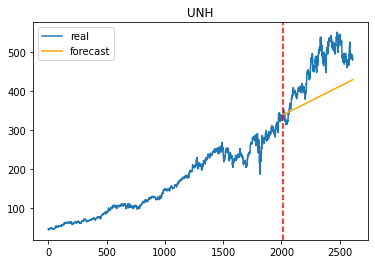

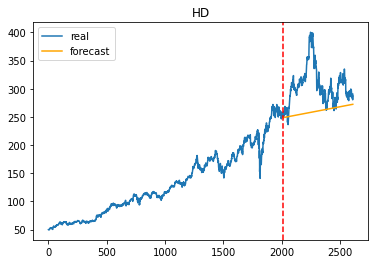

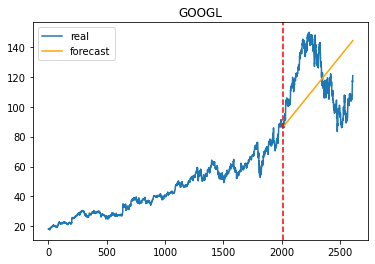

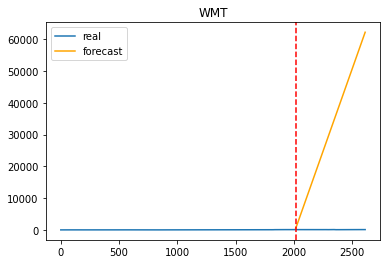

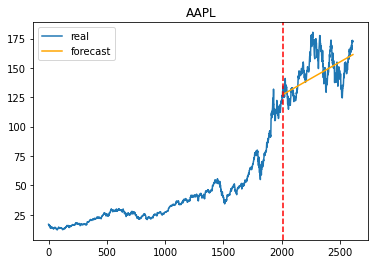

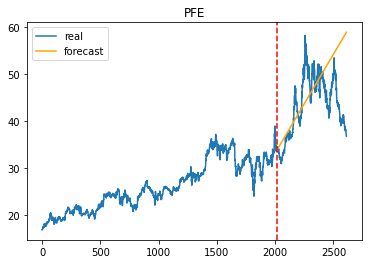

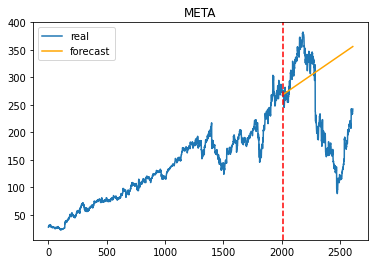

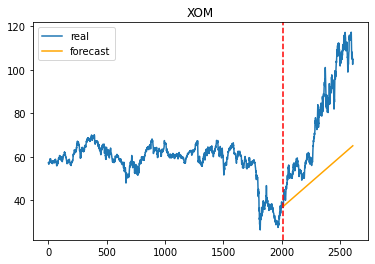

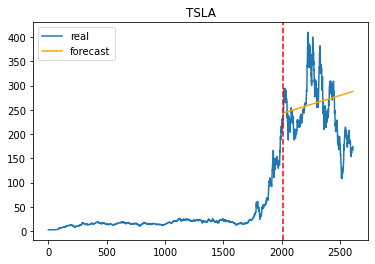

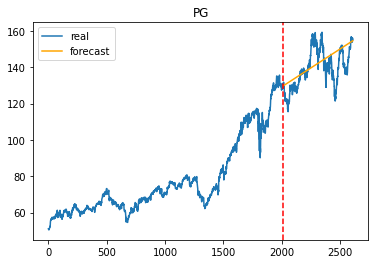

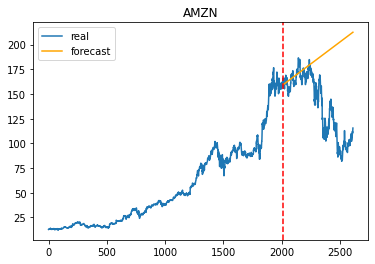

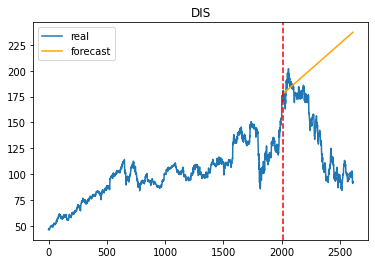

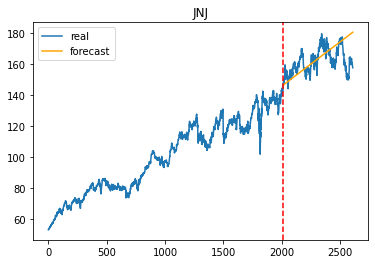

In [26]:
plot_predictions_econometric(predictions, scaled=False)

# Neural Network Forecasting

## Definition of the models and functions

In [27]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [28]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, output_size, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])  # Get the last time step output
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_length=1000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))
        pe = torch.zeros(max_length, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [30]:
def training(data: DataLoader, model, criterion, optimizer, input_size):
    # Training loop
    running_loss = 0.
    last_loss = 0.
    running_mae = 0.
    mean_absolute_error = MeanAbsoluteError().to(device)
    model.train()
    for epoch in range(NUM_EPOCHS):
        for i, batch in enumerate(data):
            X, y = batch
            predict = model(X)
            loss = criterion(predict, y)
            mae = mean_absolute_error(predict, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            running_mae += mae.item()

        if (epoch + 1) % LOG_FREQUENCY == 0:
            last_loss = running_loss/LOG_FREQUENCY
            last_mae = running_mae/LOG_FREQUENCY
            print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Loss: {last_loss}, Mae: {last_mae}')
            running_loss = 0
            running_mae = 0


def testing(data: DataLoader, model):
    # Generate predictions
    model.eval()
    mean_absolute_error = MeanAbsoluteError().to(device)
    predictions = []
    running_mae = 0
    with torch.no_grad():
        for i, batch in enumerate(data):
            X, y = batch
            predict = model(X)
            mae = mean_absolute_error(predict, y)
            running_mae += mae.item()
            predictions.append(predict.detach().cpu().numpy())
    
    print(f"Test MAE: {running_mae/len(data)}")

    # join everything into a unique matrix
    all_pred = np.zeros(N_STOCK)
    for b in predictions:
        for p in b:
            all_pred = np.vstack((all_pred, p))
    # Remove zero vector
    all_pred = all_pred[1:, :]

    return all_pred


## Neural Network Data Preprocessing

In [31]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data.values)
scaled_test = scaler.transform(test_data.values)
scaled_test = np.vstack((scaled_train[-LAG:, :], scaled_test))

In [32]:
class TimeSeriesdataset(Dataset):
    def __init__(self, lag: int, data: np.ndarray, device: torch.device):
        self.lag = lag
        self.data = data
        self.device = device

    def __len__(self):
        lenght = len(self.data)
        return lenght - (self.lag + 1)

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.lag, :].flatten()
        Y = self.data[idx+self.lag, :]
        return torch.tensor(X, device=self.device).to(torch.float32), torch.tensor(Y, device=self.device).to(torch.float32)

In [33]:
train_dataset = TimeSeriesdataset(lag=LAG, data=scaled_train, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TimeSeriesdataset(lag=LAG, data=scaled_test, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model, training and testing

In [34]:
# Create the LSTM model
modelLSTM = LSTM(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK).to(device)
modelTransformer = TransformerModel(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizerLSTM = optim.Adam(modelLSTM.parameters())
optimizerTransformer = optim.Adam(modelTransformer.parameters())

### Train

In [35]:
print("LSTM")
LSTM_train = training(train_dataloader, modelLSTM, criterion, optimizerLSTM, input_size=LAG*N_STOCK)
print('*'*50)
print("Transformer")
Transformer_train = training(train_dataloader, modelTransformer, criterion, optimizerTransformer, input_size=LAG*N_STOCK)

LSTM
Epoch: 10/100, Loss: 0.9187567414599471, Mae: 5.484207432344556
Epoch: 20/100, Loss: 0.31275299447006544, Mae: 3.2109115326777102
Epoch: 30/100, Loss: 0.22625293338205665, Mae: 2.7787232849746943
Epoch: 40/100, Loss: 0.20449249725788832, Mae: 2.6878599958494305
Epoch: 50/100, Loss: 0.13590427151939366, Mae: 2.1584775956347584
Epoch: 60/100, Loss: 0.13565246778598522, Mae: 2.192299373354763
Epoch: 70/100, Loss: 0.17776522403000855, Mae: 2.5618496743962167
Epoch: 80/100, Loss: 0.13925023022457025, Mae: 2.2776464181020857
Epoch: 90/100, Loss: 0.12371879440615885, Mae: 2.142255746014416
Epoch: 100/100, Loss: 0.11944502013502642, Mae: 2.085085988231003
**************************************************
Transformer
Epoch: 10/100, Loss: 3.7554955528117717, Mae: 11.654827487468719
Epoch: 20/100, Loss: 1.5966337306890637, Mae: 7.551784226670861
Epoch: 30/100, Loss: 0.8575845934450627, Mae: 5.557709570229053
Epoch: 40/100, Loss: 1.3978364568436519, Mae: 6.613600850105286
Epoch: 50/100, Loss

### Test

In [36]:
print("LSTM")
LSTM_test = testing(test_dataloader, modelLSTM)
print('*'*50)
print("Transformer")
Transformer_test = testing(test_dataloader, modelTransformer)

LSTM
Test MAE: 0.30817583595451553
**************************************************
Transformer
Test MAE: 0.3363645931607799


## NN Performance Plots

In [37]:
def plot_predictions(predictions):
    all_pred = predictions
    all_pred = scaler.inverse_transform(all_pred)

    dates = np.concatenate((train_data.index, test_data.index))
    # Convert the dates to datetime objects
    dates = pd.to_datetime(dates)
    
    all_real = np.concatenate((scaled_train, scaled_test))
    all_real = scaler.inverse_transform(all_real)
    all_real.shape[0]

    for idx, file_name in enumerate(files):
        stock = file_name[:-4]
        index_test_start = all_real[:, 0].shape[0] - all_pred.shape[0]
        plt.figure()
        plt.plot( range(all_real.shape[0]) , all_real[:, idx], label='real')
        plt.plot( range(index_test_start,all_real.shape[0]), all_pred[:, idx], color='orange', label='forecast')
        plt.axvline(x=index_test_start, color='red', linestyle='--')
        plt.title(stock)

        # Calculate the tick positions
        total_ticks = len(dates)
        desired_ticks = 16
        step = max(1, int(np.ceil(total_ticks / desired_ticks)))
        tick_positions = np.arange(0, total_ticks, step)
        # Set the tick positions and labels
        plt.xticks(tick_positions, dates[tick_positions].strftime('%Y-%m-%d'), rotation=45)
    
        plt.gca().grid(True)

        plt.legend()
        plt.show()


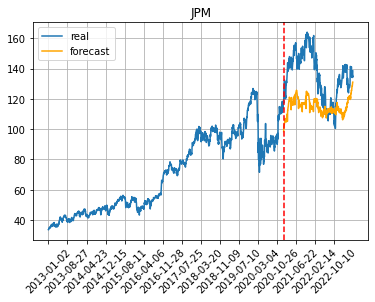

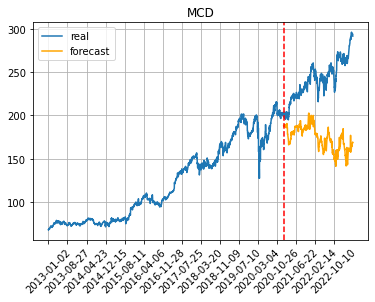

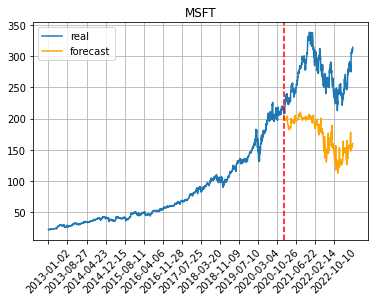

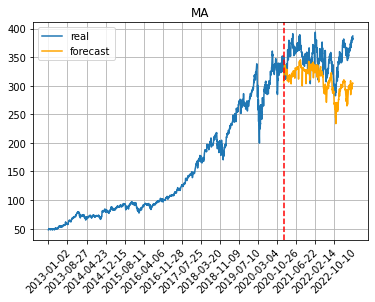

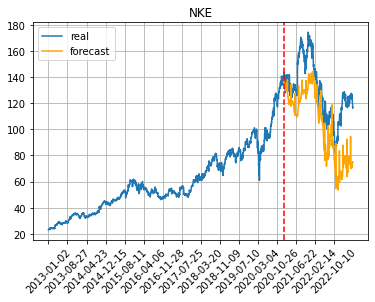

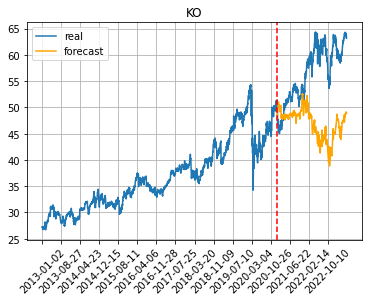

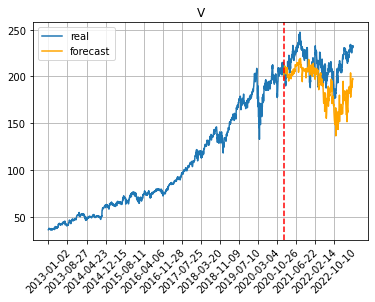

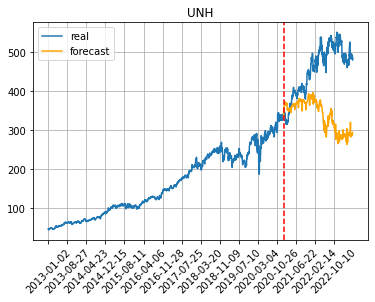

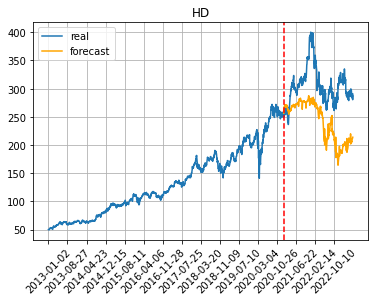

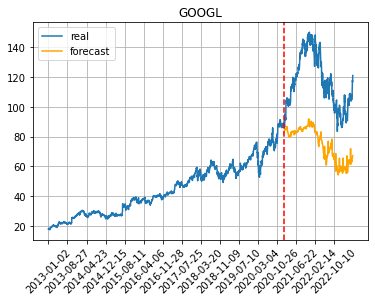

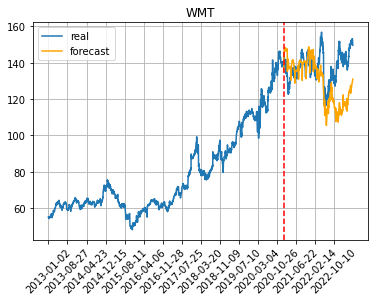

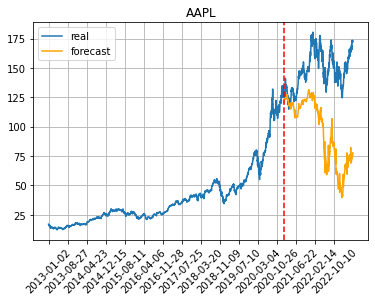

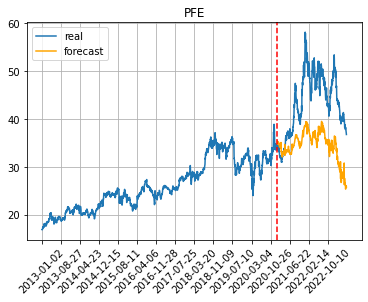

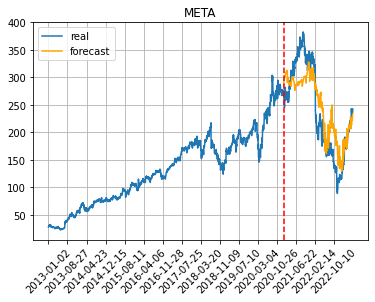

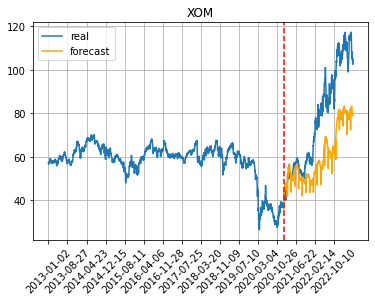

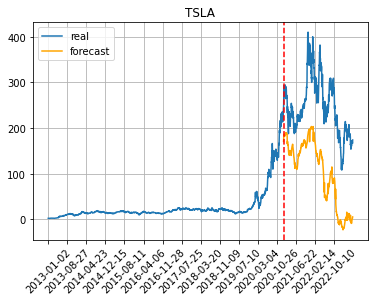

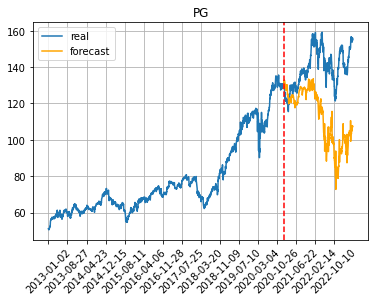

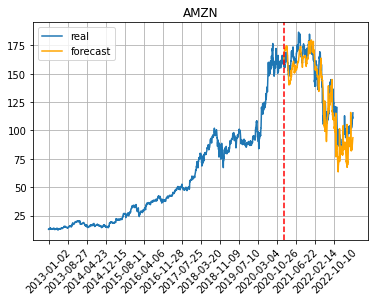

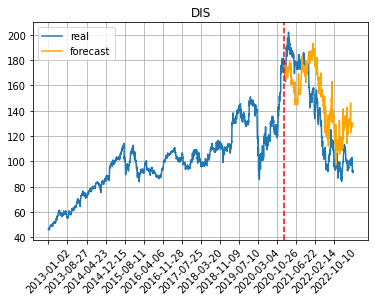

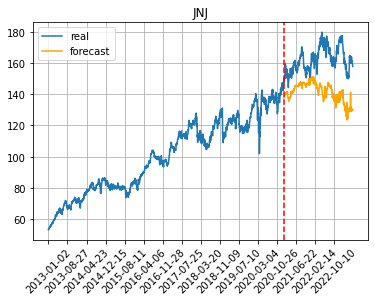

In [38]:
plot_predictions(LSTM_test)

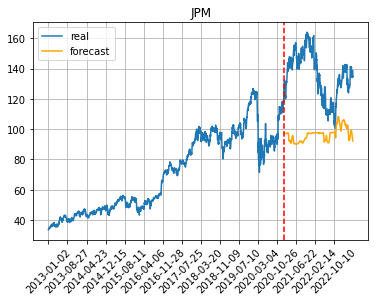

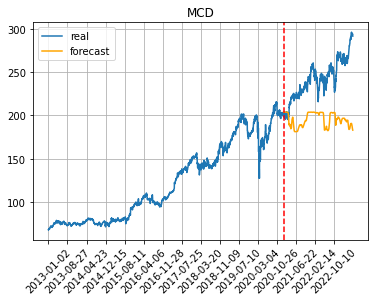

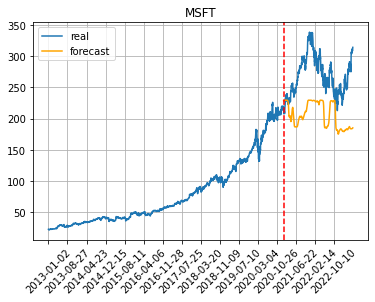

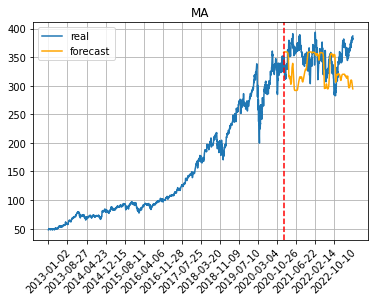

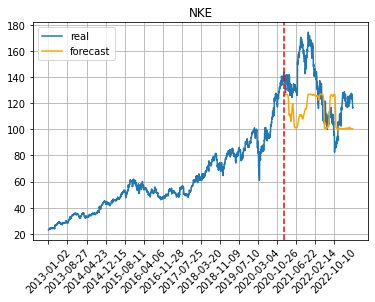

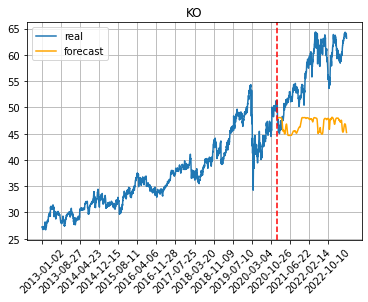

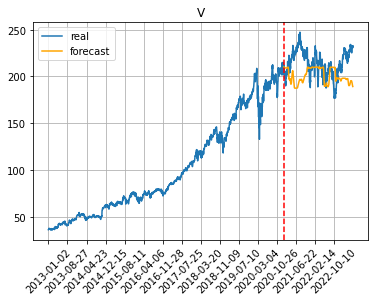

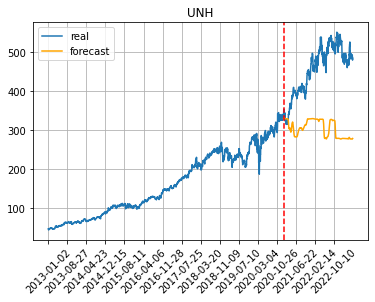

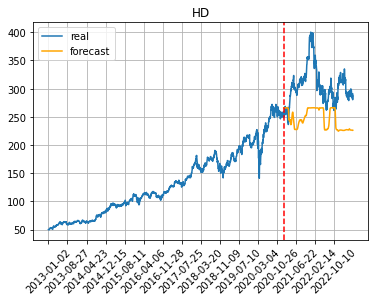

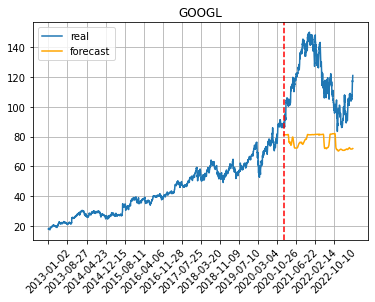

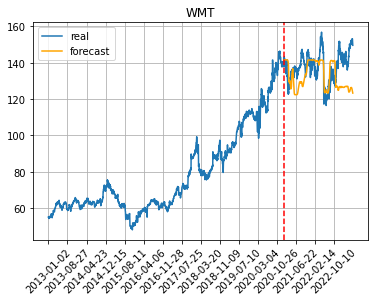

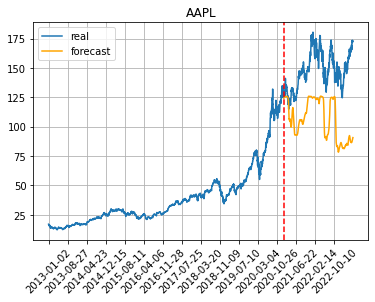

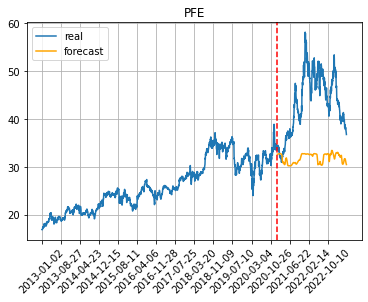

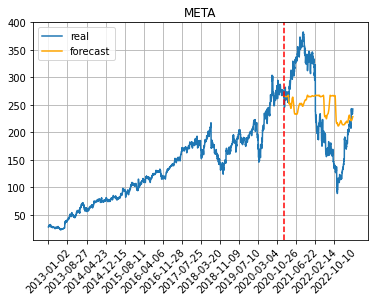

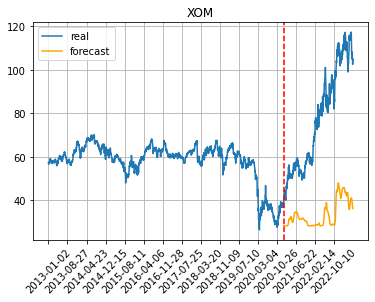

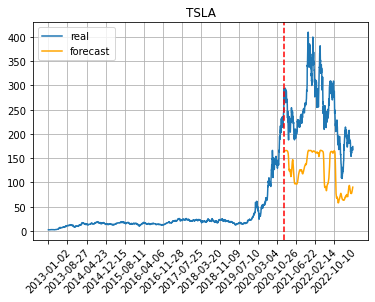

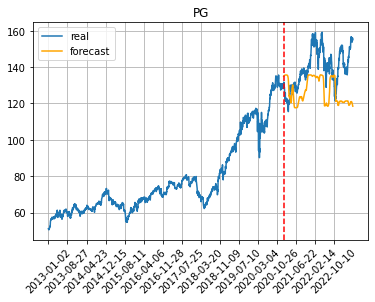

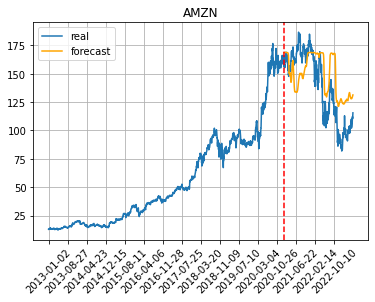

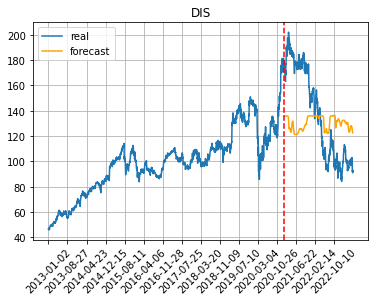

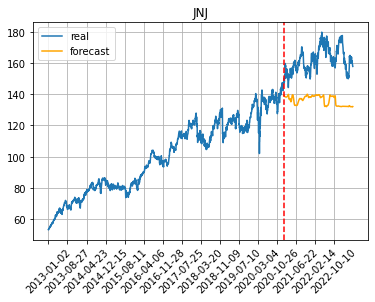

In [39]:
plot_predictions(Transformer_test)

# Porfolio Optimizaion

In [40]:
# Algorithm Network
class Dqn(nn.Module):

    def __init__(self, n_inputs, n_outputs, n_layer, n_nodes):
        super().__init__()
        self.n_layer = n_layer
        self.n_outputs = n_outputs

        self.input_layer = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=n_nodes),
            nn.ReLU()
        )

        self.hidden_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(in_features=n_nodes, out_features=n_nodes),
                    nn.ReLU()
                )
                for _ in range(n_layer - 1)]
        )

        self.output_layer = nn.Linear(in_features=n_nodes, out_features=n_outputs)

    def forward(self, x):
        input_layer_out = self.input_layer(x.type(torch.float32))

        hidden_layers_out = self.hidden_layers[0](input_layer_out)
        for i in range(0, self.n_layer - 1):
            hidden_layers_out = self.hidden_layers[i](hidden_layers_out)

        output = self.output_layer(hidden_layers_out)

        return output

# General Class for the agent containing some utility functions
class Agent:
    def __init__(self, n_asset, input_size):
        self.n_asset = n_asset
        self.action_space = 40  # 0 BUY, 1 SELL
        self.nLayers = 10
        self.nNodes = 32

        self.alpha = 0.5  # learning rate
        self.gamma = 0.95  # discount factor
        self.epsilon = 1  # action epsilon-greedy --> then multiplied by 0.999

        self.epsilon_avoid_0 = 1e-9  # epsilon in order to avoid division by 0
        self.DQN_net = Dqn(n_inputs=input_size, n_outputs=self.action_space, n_layer=self.nLayers,
                           n_nodes=self.nNodes).to(DEVICE)

    def act(self, state):
        # with epsilon probability choose random
        self.epsilon *= 0.999  # epsilon greedy action selection decrease over time
        if random.random() < self.epsilon:
            # random choice an action to perform
            weights = np.random.uniform(-5, 5, size=self.n_asset)

            weights_sum = np.sum(weights) + self.epsilon_avoid_0
            weights /= weights_sum
            weights = torch.tensor(weights, device=DEVICE).view(1, self.n_asset)
            best_actions = torch.randint(low=0, high=2, size=(20,), device=DEVICE)

        # otherwise perform the best actions
        else:
            # select q(s,a) from network
            linear_actions = self.DQN_net(state)
            # Reshape the output of the network into a (20, 2) tensor
            linear_actions = linear_actions.reshape(int(linear_actions.shape[0] / 2), 2)
            # select best actions from network output
            best_actions = torch.argmax(linear_actions, dim=1)

            weights = torch.empty((1, self.n_asset), device=DEVICE)

            # iterate over the actions
            for index, value in enumerate(best_actions):
                if value == 0:  # BUY
                    weights[0][index] = linear_actions[index][value]
                else:  # SELL
                    weights[0][index] = -linear_actions[index][value]

            # normalize the weights to sum to 1
            weights_sum = torch.sum(weights) + self.epsilon_avoid_0
            weights /= weights_sum

        return weights, best_actions


@dataclass
class State:
    # Covariance matrix
    cov: torch.Tensor
    # Weights of the portfolio at time t-1
    last_allocation: torch.Tensor
    # Value of the Portfolio
    portfolio_value: float
    # Pct Change
    data: torch.Tensor
    # Expected ShortFall
    es: torch.Tensor

    def __len__(self):
        return self.cov.shape[0] * self.cov.shape[1] + self.last_allocation.shape[1] + 1 + \
            self.data.shape[0] * self.data.shape[1] + self.data.shape[1]

    def flatten(self):
        return torch.cat(
            (
                self.cov.flatten(),
                self.last_allocation.flatten(),
                torch.tensor([self.portfolio_value], device=DEVICE).flatten(),
                self.data.flatten(),
                self.es.flatten()
            )
        )

    @classmethod
    def from_flatten(cls, flat_state: torch.Tensor, n_stock: int, lag: int):
        cov = flat_state[:n_stock * 2].reshape((n_stock, n_stock))
        last_allocation = flat_state[n_stock * 2: n_stock * 2 + n_stock]
        portfolio_value = flat_state[n_stock * 2 + n_stock]
        data = flat_state[n_stock * 2 + n_stock + 1:-1].reshape((lag, n_stock))
        es = flat_state[-1:0]
        s = cls(cov, last_allocation, portfolio_value, data, es)
        return s

In [41]:
class Environment:
    def __init__(self, path_assets, money):
        self.path_assets = path_assets
        self.money = money
        self.money_reset = money
        self.dates = None
        self.data = self.load_data()

    def load_data(self):
        # read aggregated data like Dataframe and then convert it to a Tensor
        # Finally compute the daily % return
        data = pd.read_csv(self.path_assets)
        self.dates = data['Date'].copy(deep=True)
        data = data.drop(columns=['Date'])
        data = torch.tensor(data.values, device=DEVICE)
        # A vector of zeros with shape 1, N_STOCK
        data_copy = torch.zeros((1, data.shape[1]), device=DEVICE)
        data_copy = torch.cat((data_copy, data[:-1]))
        res = (((data - data_copy) / data_copy) * 100)[1:, :]
        return res

    def get_new_state(self, t: int, lag: int, last_alloc, portfolio_val: float, confidence_level):
        data_lag = self.data[t - lag:t, :]

        # compute covariance matrix for lag prices ago till t
        cov_matrix = torch.cov(data_lag.t())

        # compute VaR
        sorted_returns, _ = torch.sort(data_lag, dim=0)
        var_position = int(torch.floor((1 - torch.tensor(confidence_level, device=DEVICE)) * data_lag.shape[1]))
        var = -sorted_returns[:, var_position]

        # Calculate ES for each asset
        es = -sorted_returns[:var_position, :].mean(dim=0)

        return State(cov_matrix, last_alloc, portfolio_val, data_lag, es)

    def get_reward(self, weights, next_day_reward, lag, es):
        # get percentage change of t+1
        next_day = self.data[next_day_reward, :]
        # compute the allocation in real money to each asset
        allocation_money = weights * self.money

        reward = 0
        risk_free_rate = 5.12  # USA Department of Treasury (3 months interest rate)

        # iterate over each percentage
        for index, pct_value in enumerate(next_day):
            money_this_asset = allocation_money[0][index]
            variation_money_this_asset = (pct_value / 100) * money_this_asset
            self.money += variation_money_this_asset

            action_weight = weights[0][index]

        rets = self.data[next_day_reward - lag:next_day_reward, :]
        rets_mean = torch.mean(rets, dim=0)
        rets_cov = torch.cov(rets.t())
        P_ret = torch.sum(rets_mean * weights)
        P_dev_std = torch.sqrt(
            torch.mm(
                weights.to(torch.float32), 
                torch.mm(rets_cov.to(torch.float32), weights.t().to(torch.float32))
            )
        )
        P_sharpe = (P_ret - risk_free_rate) / P_dev_std
        # Good Sharpe ratio
        reward = P_sharpe.squeeze(1).item()

        done = 1 if self.money < 0 else 0
        if done:
            self.money = self.money_reset

        return reward, done

In [42]:
def DQNUpdate(neural_net, memory_buffer, optimizer, agent, device, state_dim: int, BATCH_SIZE):
    """
    Main update rule for the DQN process. Extract data from the memory buffer and update
    the newtwork computing the gradient.

    """
    criterion = nn.MSELoss()

    if len(memory_buffer) < BATCH_SIZE: return

    n_asset = agent.n_asset
    gamma = agent.gamma
    # memory_buffer = memory_buffer[torch.randperm(memory_buffer.shape[0])][:BATCH_SIZE, :]
    memory_buffer = memory_buffer[-BATCH_SIZE:, :]

    state = memory_buffer[:, :state_dim]
    action = memory_buffer[:, state_dim:state_dim + n_asset]
    next_state = memory_buffer[:, state_dim + n_asset:(state_dim * 2) + n_asset]
    reward = memory_buffer[:, (state_dim * 2) + n_asset].reshape(BATCH_SIZE, 1)
    done = memory_buffer[:, (state_dim * 2) + n_asset + 1].reshape(BATCH_SIZE, 1)

    with torch.no_grad():

        target = neural_net(state)

        target_copy = torch.clone(target)
        target_copy = target_copy.reshape(target_copy.shape[0], int(target_copy.shape[1] / 2), 2)

        # if done --> to_update = reward
        output_net = neural_net(next_state)
        output_net = output_net.reshape(output_net.shape[0], int(output_net.shape[1] / 2), 2)
        to_update = reward + torch.max(output_net, 2).values * gamma * (1 - done)

        for row_n in range(target_copy.shape[0]):
            for column_n in range(target_copy.shape[1]):
                target_copy[row_n, column_n, action[row_n, column_n].to(torch.int32)] = to_update[row_n][column_n]

        predicted = neural_net(state)
        predicted = predicted.reshape(predicted.shape[0], int(predicted.shape[1] / 2), 2)

    predicted.requires_grad = True
    target_copy.requires_grad = True

    objective_done = criterion(predicted.to(torch.float32), target_copy.to(torch.float32))

    optimizer.zero_grad()
    objective_done.backward()
    optimizer.step()

In [43]:
def train():
    # Expected Shortfall threshold
    confidence_level = 0.95

    # Environment() parameters
    path_assets = 'AGGREGATED_DATA.csv'
    lag = 5
    money = 10_000
    # Agent() parameters
    n_asset = 20

    # instantiate environment
    env = Environment(path_assets=path_assets, money=money)
    data = env.data

    initial_alloc = torch.zeros((1, 20), device=DEVICE)
    state = env.get_new_state(t=lag + 1, lag=lag, last_alloc=initial_alloc, portfolio_val=env.money,
                              confidence_level=confidence_level)
    STATE_DIM = len(state)
    # instantiate agent
    agent = Agent(n_asset=n_asset, input_size=STATE_DIM)

    # index to split train-test
    percentage_train = 80
    index_train = int((percentage_train / 100) * data.shape[0])

    # set limit memory
    BATCH_SIZE = 16

    # instantiate the optimizer
    optimizer_learning_rate = 0.0001
    optimizer = torch.optim.Adam(agent.DQN_net.parameters(), lr=optimizer_learning_rate)

    # memory buffer and its dimensionality
    # ATTRIBUTE
    # state,            action,      next_state,        reward       done
    # DIMENSION
    # LEN STATE         n_asset      LEN STATE     1             1
    memory_buffer = torch.empty((0, (STATE_DIM * 2) + 2 + n_asset), device=DEVICE)

    # iterate over all t in train part
    episode = 1
    reward_evolution = []
    for next_t in range(lag + 2, index_train):
        weights, best_actions = agent.act(state.flatten())
        reward, done = env.get_reward(weights=weights, next_day_reward=next_t, lag=lag, es=state.es)
        next_state = env.get_new_state(t=next_t, lag=lag, last_alloc=weights, portfolio_val=env.money,
                                       confidence_level=confidence_level)
        reward_evolution.append(reward)
        step = torch.cat(
            (
                state.flatten(),
                best_actions.flatten(),
                next_state.flatten(),
                torch.tensor(reward, device=DEVICE).flatten(),
                torch.tensor(done, device=DEVICE).flatten())
        )
        memory_buffer = torch.cat((memory_buffer, step.view(1, step.shape[0])), dim=0)
        state = next_state

        # TRAINING LAUNCH
        if len(memory_buffer) >= BATCH_SIZE:
            for _ in range(10):
                DQNUpdate(neural_net=agent.DQN_net, memory_buffer=memory_buffer,
                          optimizer=optimizer, agent=agent, device=DEVICE, state_dim=STATE_DIM, BATCH_SIZE=BATCH_SIZE)
        # averaged_rewards.append(reward)
        print(f"EPISODE {episode}, PORTFOLIO: {env.money}")
        episode += 1

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(reward_evolution)), reward_evolution, color='green', label='reward train')
    plt.axhline(y=THR_SHARPE, color='r', linestyle='-')
    plt.title('Reward evolution')
    plt.legend()
    plt.show()

    # save the net model
    torch.save(agent.DQN_net, f'DQN_net.pth')

In [44]:
def test():
    # Expected Shortfall threshold
    confidence_level = 0.95

    # Environment() parameters
    path_assets = 'AGGREGATED_DATA.csv'
    lag = 5
    money = 10_000
    # Agent() parameters
    n_asset = 20

    # instantiate environment
    env = Environment(path_assets=path_assets, money=money)
    data = env.data
    dates = env.dates

    # index to split train-test
    percentage_train = 80
    index_train = int((percentage_train / 100) * data.shape[0])
    dates = dates.iloc[index_train:]

    initial_alloc = torch.zeros((1, 20), device=DEVICE)
    state = env.get_new_state(t=index_train + lag + 1, lag=lag, last_alloc=initial_alloc, portfolio_val=env.money,
                              confidence_level=confidence_level)
    STATE_DIM = len(state)
    # instantiate agent
    agent = Agent(n_asset=n_asset, input_size=STATE_DIM)

    DQN_net = torch.load('DQN_net.pth')
    DQN_net.eval()

    episode = 1
    reward_evolution = []
    wallet_evolution = [money]
    for next_t in range(index_train, data.shape[0]):
        actions = DQN_net(state.flatten())
        actions = actions.reshape(int(actions.shape[0] / 2), 2)
        weights = torch.empty((1, agent.n_asset), device=DEVICE)

        best_actions = torch.argmax(actions, dim=1)
        for index, value in enumerate(best_actions):
            if value == 0:  # BUY
                weights[0][index] = actions[index][value]
            else:  # SELL
                weights[0][index] = -actions[index][value]

        reward, done = env.get_reward(weights=weights, next_day_reward=next_t, lag=lag, es=state.es)
        next_state = env.get_new_state(t=next_t, lag=lag, last_alloc=weights, portfolio_val=env.money,
                                       confidence_level=confidence_level)
        state = next_state

        print(f"EPISODE {episode},PORTFOLIO: {env.money}")
        wallet_evolution.append(env.money.item())
        reward_evolution.append(reward)
        episode += 1

    plt.figure(figsize=(12, 6))
    df = pd.DataFrame({"Dates": dates.values, "money": wallet_evolution})
    df.set_index('Dates', inplace=True)
    ax = df.plot.area(figsize=(12, 6), color='green')
    ax.collections[0].set_facecolor('lightblue')
    ax.collections[0].set_alpha(0.3)
    plt.xticks(rotation=45)
    plt.title('Wallet evolution')
    plt.axhline(y=money, color='r', linestyle='-')
    plt.tight_layout()
    plt.legend()
    plt.savefig('money.png', dpi=200)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(index_train, data.shape[0]), reward_evolution, color='red', label='reward test')
    plt.title('Reward evolution')
    plt.legend()
    plt.savefig('reward.png', dpi=200)
    plt.show()
    print(f"CUMULATIVE REWARD: {sum(reward_evolution)}")
    print(f"AVG REWARD: {(1/len(reward_evolution)) *sum(reward_evolution)}")

In [ ]:
train()

EPISODE 1,PORTFOLIO: 10062.545810579184
EPISODE 2,PORTFOLIO: 9954.814503467735
EPISODE 3,PORTFOLIO: 9999.349619034178
EPISODE 4,PORTFOLIO: 9986.151606931377
EPISODE 5,PORTFOLIO: 9944.73220055796
EPISODE 6,PORTFOLIO: 10024.171195189676
EPISODE 7,PORTFOLIO: 10181.271405466961
EPISODE 8,PORTFOLIO: 10202.099291233284
EPISODE 9,PORTFOLIO: 10157.444478135354
EPISODE 10,PORTFOLIO: 10106.008274966958
EPISODE 11,PORTFOLIO: 10080.891709955387
EPISODE 12,PORTFOLIO: 10173.047829498837
EPISODE 13,PORTFOLIO: 10206.968384875541
EPISODE 14,PORTFOLIO: 10089.605621639177
EPISODE 15,PORTFOLIO: 10023.42937731086
EPISODE 16,PORTFOLIO: 9898.687503291969
EPISODE 17,PORTFOLIO: 9924.670924283337
EPISODE 18,PORTFOLIO: 10035.952776479613
EPISODE 19,PORTFOLIO: 10020.424028479802
EPISODE 20,PORTFOLIO: 9916.44550281663
EPISODE 21,PORTFOLIO: 9874.861444606351
EPISODE 22,PORTFOLIO: 9978.546087063527
EPISODE 23,PORTFOLIO: 9976.414478324596
EPISODE 24,PORTFOLIO: 10099.35157085379
EPISODE 25,PORTFOLIO: 10101.26718921537

<Figure size 864x432 with 0 Axes>

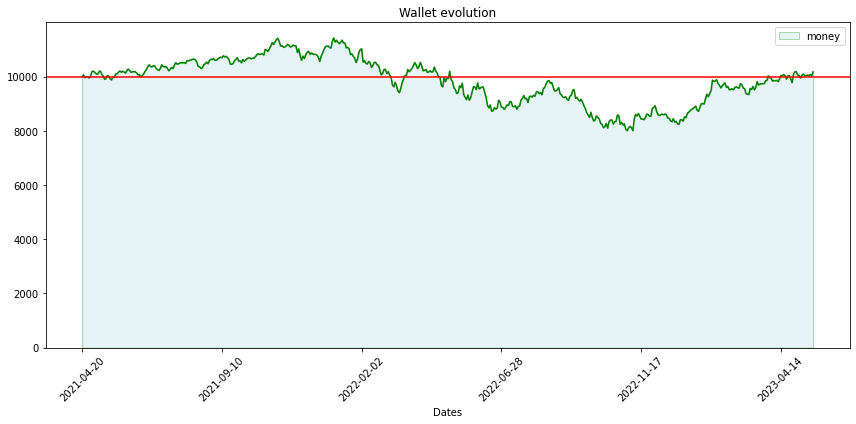

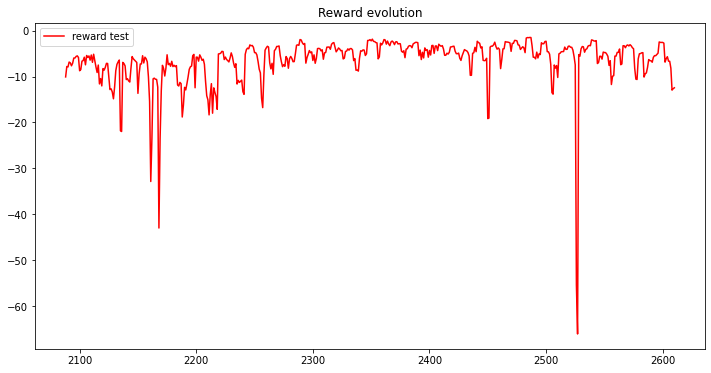

CUMULATIVE REWARD: -3371.0690536499023
AVG REWARD: -6.445638725908035


In [45]:
test()